In [ ]:
# Load necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, mean_squared_error, r2_score

# Load the disease detection model
disease_model_path = r"H:\PBL2\Btech Project\Crop Disease Detection\Crop Disease Model.h5"  # Update with your actual path
disease_model = load_model(disease_model_path)

Original Image Shape: (256, 256, 3)
Resized and Normalized Image Array Shape: (1, 224, 224, 3)
Image Array (first 5 elements): [0.85098039 0.87843137 0.74901961 0.87843137 0.90588235]


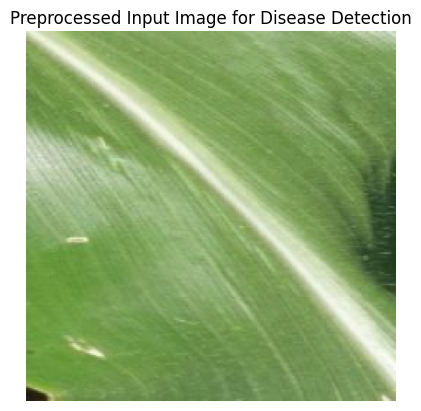

In [71]:
# Load and preprocess image for disease detection
image_path = r"G:\CropImages\Corn\Healthy\Corn Healthy (17).jpg" # Update with your actual path
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
img_resized = cv2.resize(img, (224, 224))  # Resize to model's input size
img_array = np.expand_dims(img_resized / 255.0, axis=0)  # Normalize and add batch dimension

# Display image properties
print("Original Image Shape:", img.shape)
print("Resized and Normalized Image Array Shape:", img_array.shape)
print("Image Array (first 5 elements):", img_array.flatten()[:5])

# Display the input image for visual confirmation
plt.imshow(img_resized)
plt.title("Preprocessed Input Image for Disease Detection")
plt.axis("off")
plt.show()


In [ ]:
# Function to detect disease and provide prevention advice
def detect_disease(img_array):
    predictions = disease_model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    class_labels = {0: "Healthy", 1: "Disease A", 2: "Disease B"}  # Update with actual class labels
    prevention_advice = {
    0: {"disease": "Healthy", "prevention": "No action needed."},
    
    # Corn Diseases
    1: {
        "disease": "Corn - Cercospora Leaf Spot (Gray Leaf Spot)",
        "prevention": (
            "Crop Rotation: Rotate crops with non-host plants to reduce pathogen buildup in the soil.\n"
            "Resistant Varieties: Use disease-resistant corn varieties when available.\n"
            "Fungicide Application: Apply fungicides at the early stages if high disease pressure is anticipated, "
            "following local guidelines.\n"
            "Field Management: Remove crop residue from the field, as the fungus survives in debris."
        )
    },
    2: {
        "disease": "Corn - Common Rust",
        "prevention": (
            "Resistant Varieties: Plant corn varieties that are resistant to rust.\n"
            "Fungicide Application: Apply fungicides when conditions are favorable for rust development, "
            "especially during wet and humid weather.\n"
            "Good Field Hygiene: Remove and destroy infected plant debris to reduce spores in the field."
        )
    },
    3: {
        "disease": "Corn - Northern Leaf Blight",
        "prevention": (
            "Crop Rotation and Residue Management: Rotate crops and remove crop residues, which can harbor the fungus.\n"
            "Resistant Hybrids: Choose corn hybrids with resistance to Northern Leaf Blight.\n"
            "Timely Fungicide Application: Apply fungicides during periods of prolonged leaf wetness and moderate "
            "temperatures, when blight risk is high."
        )
    },

    # Rice Diseases
    4: {
        "disease": "Rice - Bacterial Blight",
        "prevention": (
            "Resistant Varieties: Use resistant rice varieties to reduce disease incidence.\n"
            "Balanced Fertilization: Avoid excessive nitrogen, which can increase susceptibility to bacterial blight.\n"
            "Water Management: Avoid water stagnation and ensure proper drainage to reduce bacterial growth.\n"
            "Seed Treatment: Use certified disease-free seeds and treat seeds with hot water or bactericides if necessary."
        )
    },
    5: {
        "disease": "Rice - Brown Spot",
        "prevention": (
            "Balanced Fertilization: Ensure adequate phosphorus and potassium to improve plant resistance.\n"
            "Proper Water Management: Avoid water stress by ensuring proper irrigation, as drought can increase "
            "susceptibility.\n"
            "Seed Treatment: Use treated seeds to prevent disease introduction."
        )
    },
    6: {
        "disease": "Rice - Leaf Smut",
        "prevention": (
            "Resistant Varieties: Select rice varieties with resistance to leaf smut.\n"
            "Fungicide Application: Use fungicides if the disease is severe, following local agricultural guidelines.\n"
            "Remove Infected Residues: Dispose of infected plant debris to reduce sources of infection."
        )
    },

    # Wheat Diseases
    7: {
        "disease": "Wheat - Septoria",
        "prevention": (
            "Resistant Varieties: Choose wheat varieties resistant to Septoria.\n"
            "Crop Rotation: Rotate with non-host crops to reduce fungal spores in the soil.\n"
            "Fungicide Application: Apply fungicides at the beginning of flowering if conditions favor disease "
            "development.\n"
            "Avoid Overcrowding: Plant at recommended densities to ensure good air circulation."
        )
    },
    8: {
        "disease": "Wheat - Stripe Rust",
        "prevention": (
            "Resistant Varieties: Use wheat varieties that are resistant to stripe rust.\n"
            "Early Detection and Fungicide Application: Apply fungicides if stripe rust is detected early, especially "
            "during cool and moist conditions.\n"
            "Good Field Hygiene: Remove volunteer wheat plants and other hosts that can harbor the disease."
        )
    }
}

    # Print the prediction results
    print("Predicted Class ID:", predicted_class)
    print("Disease Name:", class_labels.get(predicted_class, "Unknown"))
    if predicted_class > 0:
        print("Prevention Advice:", prevention_advice.get(predicted_class, "No advice available."))
    else:
        print("The plant is healthy; no action needed.")

# Run disease detection
detect_disease(img_array)



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Class ID: 1
Disease Name: Disease A
Prevention Advice: Use antifungal spray weekly.


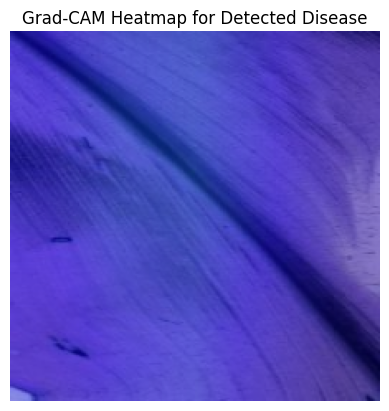

In [73]:
# Function to generate Grad-CAM heatmap
def grad_cam(model, img_array, layer_name="conv2d_281"):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = np.maximum(conv_outputs @ pooled_grads[..., tf.newaxis], 0)
    heatmap = tf.squeeze(heatmap) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Display Grad-CAM
heatmap = grad_cam(disease_model, img_array, layer_name="conv2d_281")
img_overlay = cv2.resize(heatmap, (img_resized.shape[1], img_resized.shape[0]))
img_overlay = cv2.applyColorMap(np.uint8(255 * img_overlay), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(np.uint8(255 * img_resized), 0.6, img_overlay, 0.4, 0)

plt.imshow(superimposed_img)
plt.title("Grad-CAM Heatmap for Detected Disease")
plt.axis("off")
plt.show()


In [74]:
# Load crop yield dataset
yield_data_path = r"G:\crop_yield.csv"  # Update with your actual path
df = pd.read_csv(yield_data_path)
print("First 5 rows of crop yield dataset:")
print(df.head())

# Display dataset columns for verification
print("Columns in the dataset:", df.columns.tolist())


First 5 rows of crop yield dataset:
    Crop  Crop_Year       Season      State      Area  Production  \
0  Maize       1997  Kharif           Assam   19216.0       14721   
1  Maize       1997  Kharif       Karnataka  502797.0     1391132   
2  Maize       1997  Rabi         Karnataka   48844.0       98932   
3  Maize       1997  Summer       Karnataka    9730.0       20893   
4  Maize       1997  Kharif       Meghalaya   17175.0       24878   

   Annual_Rainfall   Fertilizer  Pesticide     Yield  
0           2051.4   1828786.72    5956.96  0.615652  
1           1266.7  47851190.49  155867.07  2.687778  
2           1266.7   4648483.48   15141.64  1.980000  
3           1266.7    926004.10    3016.30  2.165714  
4           3818.2   1634544.75    5324.25  1.444286  
Columns in the dataset: ['Crop', 'Crop_Year', 'Season', 'State', 'Area', 'Production', 'Annual_Rainfall', 'Fertilizer', 'Pesticide', 'Yield']


In [ ]:
import pandas as pd
import joblib

# Define the exact feature columns that the model was trained on
EXPECTED_FEATURE_COLUMNS = [
    "Crop", "Crop_Year", "Season", "State", "Area", "Production", 
    "Annual_Rainfall", "Fertilizer", "Pesticide"
]

# Updated Function for yield prediction using actual dataset columns
def predict_yield(state, crop, area, model, dataset):
    # Filter dataset for user-specified state and crop
    filtered_df = dataset[(dataset['State'].str.lower() == state.lower()) & 
                          (dataset['Crop'].str.lower() == crop.lower())]
    
    if filtered_df.empty:
        print("No data available for the specified crop and state.")
        return None

    # Prepare the feature vector with the expected columns
    features = pd.DataFrame(columns=EXPECTED_FEATURE_COLUMNS)
    features.loc[0, 'Crop'] = crop  # User-specified area
    features.loc[0, 'Area'] = area  # User-specified area
    features.loc[0, 'Production'] = filtered_df['Production'].mean()  # Mean value for Production
    features.loc[0, 'Annual_Rainfall'] = filtered_df['Annual_Rainfall'].mean()  # Mean Rainfall
    features.loc[0, 'Fertilizer'] = filtered_df['Fertilizer'].mean()  # Mean Fertilizer
    features.loc[0, 'Pesticide'] = filtered_df['Pesticide'].mean()  # Mean Pesticide
    features.loc[0, 'Crop_Year'] = 2024  # Set to current or desired crop year
    features.loc[0, 'Season'] = "Kharif"  # Example season (customize as needed)
    features.loc[0, 'State'] = state  # Set state name directly

    # Convert categorical features to numeric encoding if required
    features = pd.get_dummies(features)

    # Add missing columns if any are absent in the input data
    missing_cols = set(EXPECTED_FEATURE_COLUMNS) - set(features.columns)
    for col in missing_cols:
        features[col] = 0  # Add any missing columns as 0

    # Ensure the order of columns matches the model's expected feature order
    features = features[EXPECTED_FEATURE_COLUMNS]

    # Predict and display results
    predicted_yield = model.predict(features)[0]
    print(f"Predicted yield for {crop} in {state}: {predicted_yield:.2f} tons per ha")
    return predicted_yield

# Sample prediction
state = "Assam"
crop = "Rice"
area = 20000
yield_model_path = r"H:\PBL2\Btech Project\Crop Yield Detection\Yield Model.pkl"  # Update with actual path
yield_model = joblib.load(yield_model_path)  # Load your saved model

# Load dataset
df_path = r"G:\crop_yield.csv"  # Update with the actual path to your dataset
df = pd.read_csv(df_path)

# Run the prediction
predicted_yield = predict_yield(state, crop, area, yield_model, df)
print("Predicted Yield:", predicted_yield)


Predicted yield for Rice in Assam: 2.04 tons per ha
Predicted Yield: 2.0422736182798475


C:\Users\aryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


C:\Users\aryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Predicted yield for Rice in Assam: 2.04 tons per ha

SHAP values for rf model:
Crop: 0.0127
Crop_Year: -0.0798
Season: 0.1014
State: -0.1895
Area: -0.3074
Production: 0.4479
Annual_Rainfall: -0.0703
Fertilizer: -0.0720
Pesticide: -0.0831


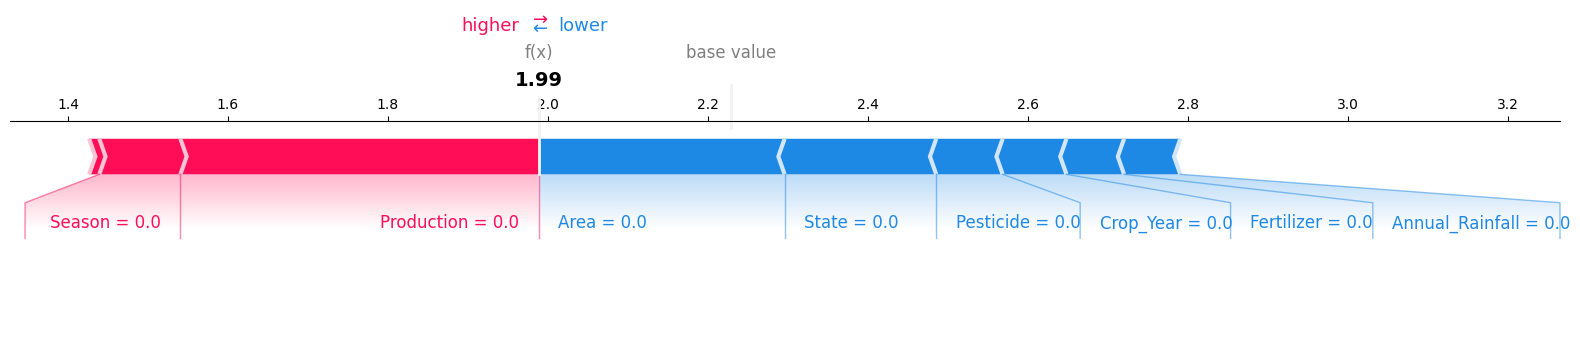


SHAP values for xgb model:
Crop: 0.0264
Crop_Year: -0.0534
Season: -0.0412
State: -0.1833
Area: -0.3863
Production: 0.7285
Annual_Rainfall: -0.0492
Fertilizer: -0.0870
Pesticide: -0.0872


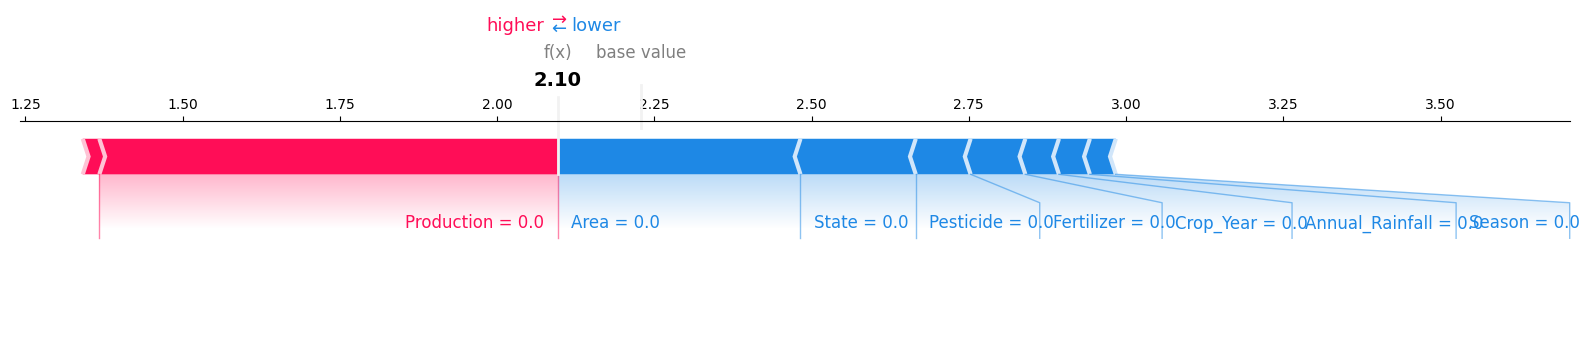


Aggregated SHAP values across models:
Crop: 0.0195
Crop_Year: -0.0666
Season: 0.0301
State: -0.1864
Area: -0.3468
Production: 0.5882
Annual_Rainfall: -0.0598
Fertilizer: -0.0795
Pesticide: -0.0851


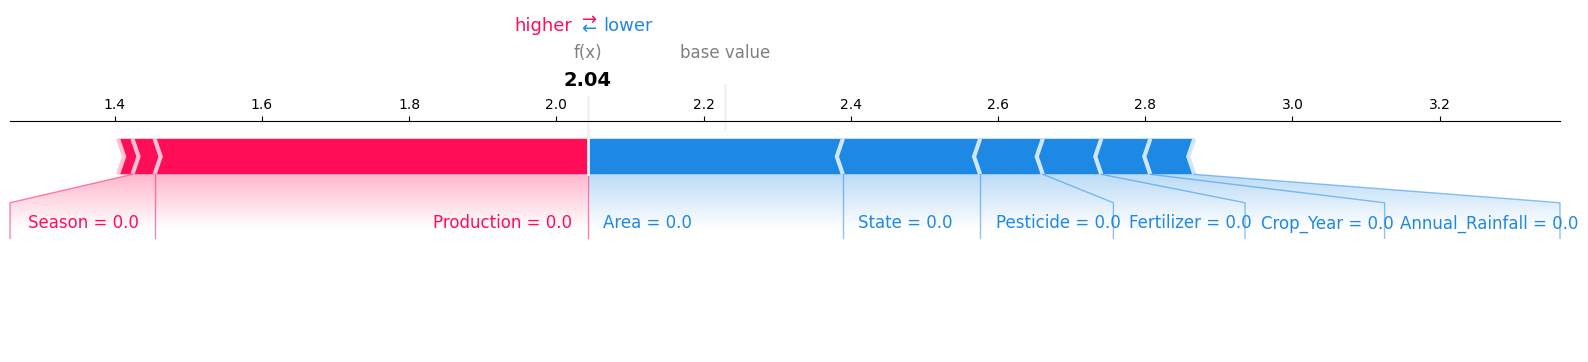

Predicted Yield: 2.0422736182798475


In [101]:
import pandas as pd
import joblib
import shap
import matplotlib.pyplot as plt

# Define the exact feature columns expected by each model
EXPECTED_FEATURE_COLUMNS = [
    "Crop", "Crop_Year", "Season", "State", "Area", "Production",
    "Annual_Rainfall", "Fertilizer", "Pesticide"
]

# Updated function for yield prediction and SHAP explanation for VotingRegressor
def predict_yield_with_explanation(state, crop, area, model, dataset):
    # Filter dataset for user-specified state and crop
    filtered_df = dataset[(dataset['State'].str.lower() == state.lower()) & 
                          (dataset['Crop'].str.lower() == crop.lower())]
    
    if filtered_df.empty:
        print("No data available for the specified crop and state.")
        return None

    # Prepare the feature vector
    features = pd.DataFrame(columns=EXPECTED_FEATURE_COLUMNS)
    features.loc[0, 'Crop'] = crop
    features.loc[0, 'Crop_Year'] = 2024  # Example year
    features.loc[0, 'Season'] = "Kharif"  # Example season
    features.loc[0, 'State'] = state
    features.loc[0, 'Area'] = area
    features.loc[0, 'Production'] = filtered_df['Production'].mean()
    features.loc[0, 'Annual_Rainfall'] = filtered_df['Annual_Rainfall'].mean()
    features.loc[0, 'Fertilizer'] = filtered_df['Fertilizer'].mean()
    features.loc[0, 'Pesticide'] = filtered_df['Pesticide'].mean()

    # Convert categorical features to numeric encoding if required
    features = pd.get_dummies(features)

    # Add missing columns if any are absent in the input data
    missing_cols = set(EXPECTED_FEATURE_COLUMNS) - set(features.columns)
    for col in missing_cols:
        features[col] = 0  # Add any missing columns as 0

    # Ensure the order of columns matches the model's expected feature order
    features = features[EXPECTED_FEATURE_COLUMNS]

    # Predict yield
    predicted_yield = model.predict(features)[0]
    print(f"Predicted yield for {crop} in {state}: {predicted_yield:.2f} tons per ha")

    # SHAP Explanation for each model in VotingRegressor
    shap_values_list = []
    for name, individual_model in model.estimators:
        explainer = shap.TreeExplainer(individual_model)
        shap_values = explainer.shap_values(features)
        shap_values_list.append(shap_values)

        # Display SHAP values for this prediction for each individual model
        print(f"\nSHAP values for {name} model:")
        for col, shap_value in zip(features.columns, shap_values[0]):
            print(f"{col}: {shap_value:.4f}")

        # Display SHAP force plot for each individual model
        shap.initjs()  # Load JS visualization for Jupyter notebooks
        shap.force_plot(explainer.expected_value, shap_values[0], features, matplotlib=True)
        plt.show()

    # Aggregate SHAP values across models if needed
    averaged_shap_values = sum(shap_values_list) / len(shap_values_list)

    # Display aggregated SHAP values
    print("\nAggregated SHAP values across models:")
    for col, shap_value in zip(features.columns, averaged_shap_values[0]):
        print(f"{col}: {shap_value:.4f}")

    # Aggregated SHAP force plot (optional)
    shap.force_plot(explainer.expected_value, averaged_shap_values[0], features, matplotlib=True)
    plt.show()

    return predicted_yield

# Sample prediction with explanation
state = "Assam"
crop = "Rice"
area = 20000
yield_model_path = r"H:\PBL2\val\haha.pkl"  # Update with actual path
yield_model = joblib.load(yield_model_path)  # Load your saved model

# Load dataset
df_path = r"G:\crop_yield.csv"  # Update with the actual path to your dataset
df = pd.read_csv(df_path)

# Run the prediction with explanation
predicted_yield = predict_yield_with_explanation(state, crop, area, yield_model, df)
print("Predicted Yield:", predicted_yield)
